# Predicting the Century of a Photograph: A Hello World Classification Model with PyTorch

### Goal of the session

The goal of this tutorial is to give you an introduction into the PyTorch Dataset and DataLoader. 
The notebook includes the basic code for training a model to predict whether a given photograph was taken in the 19th or 20th century.

The tutorial is organized into the following sections:

- __Data preprocessing__
- __Data loading__
- Creation and configuration of a model
- Training the model
- Model evaluation

We begin by importing the necessary libraries:

In [4]:
import os  # Provides a way of using system-dependent functionality.
import glob  # Finds all the pathnames matching a specified pattern.
import torch  # Main PyTorch module for tensor computation and gradients.
import torchvision  # Contains utilities for computer vision tasks.
from PIL import Image  # Python Imaging Library for opening, manipulating, and saving many different image file formats.
import random  # Generates pseudo-random numbers.
from tqdm.auto import tqdm as tqdm  # Provides a fast, extensible progress bar.
import torch.nn as nn  # Contains basic building blocks for graphs like layers and functions.
import torch.nn.functional as F  # Contains a variety of activation and loss functions.
import torch.optim as optim  # Contains standard optimization operations like SGD and Adam.
from matplotlib import pyplot as plt  # Provides a MATLAB-like plotting framework.
import numpy  # Provides a high-performance multidimensional array object and tools for working with these arrays.


Next, we set up our working device. If a CUDA-enabled GPU is available, we will use it for faster processing. Otherwise, we will default to using the CPU:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on {device}")

Working on cpu


# Preprocessing

In building a deep learning pipeline, one of the initial steps involves preprocessing, also known as the transformation process. This stage prepares our raw data to be in the right format and structure for use in our deep learning model. Below are the specific steps we'll be taking for our image data and why they are important:

- Convert the image to RGB: This is not always necessary. If all of your images are grayscale (black and white), you could also choose to train a model specifically on grayscale images. However, many pre-trained models and image datasets use color (RGB) images. If you're using such a model or dataset, or if your images are a mix of grayscale and color, it's a good idea to standardize on RGB. The key here is consistency - if you start with a model that expects RGB images, all your images must be RGB. If you start with a model that expects grayscale images, all your images must be grayscale. Mixing different types of images can lead to errors and inconsistent results.

- Resize the image to 224x224 pixels: All images that we feed into our deep learning model need to be the same size. This is because the model's input layer expects a fixed-size input. If the images have varying dimensions, the model can't learn effectively from them. By resizing all images to 224x224 pixels, we ensure they all have the same dimensions. The choice of 224x224 is standard in many pre-trained networks, such as those in the ImageNet database.

- Convert the image to a tensor: In the context of deep learning, a tensor is a multi-dimensional array that is a generalization of vectors and matrices to potentially higher dimensions. It is the primary data structure used by neural networks.

- Normalize the image: Normalizing an image refers to the process of standardizing the pixel values in the image. The purpose of normalizing the image is to change the range of pixel intensity values. By normalizing, we make sure that all our inputs have a similar data distribution. This makes it easier for the model to learn from and make predictions based on this standardized input. Normalized data also helps gradient descent to converge more quickly, which leads to faster training of neural networks.

In [6]:
preprocess = torchvision.transforms.Compose([
    lambda x:x.convert("RGB"),
    torchvision.transforms.Resize((224,224)), #make sure, all the pictures are the same size
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

### A quick side note: Input Shape?

(_inputs must have the same shape_ errors)

When we refer to the 'shape', we're speaking about the dimensions. For instance, a color image with dimensions of 224x224 pixels would have a shape represented as (224, 224, 3). This is because the image has a height of 224 pixels, a width of 224 pixels, and 3 color channels (Red, Green, and Blue). In contrast, a grayscale image only has one color channel. Therefore, a grayscale image of the same dimensions would have a shape of (224, 224, 1).

Now that the transformation has been defined, we're ready to take the next step. Let's prepare and load our images using two important components provided by PyTorch: the Dataset and DataLoader.

# PyTorch Dataset and DataLoader

We've provided two blocks of code that achieve the same goal. They both load data, but they do so in slightly different ways:

- Option 1 utilizes a prebuilt PyTorch class known as ImageFolder.
- Option 2 involves creating a custom class.

For beginners, it might be more convenient to use the ImageFolder class, but the data has to be structured as in our case!!. This prebuilt class is designed to streamline much of the data loading process. However, as you gain more experience, you might find that creating your own custom class offers more flexibility.

Below are some resources on how to implement both options:

- Option 1 - [ImageFolder class](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)
- Option 2 - [Building a custom class](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset)

Now, you might be asking, what are Dataset and DataLoader, and how do they differ?

A Dataset is the actual data that we'll use to train our model, preprocessed in a certain way as defined above. However, attempting to train a model with the entire dataset all at once can be memory-intensive and time-consuming.

That's where DataLoader comes into play. DataLoader helps manage your data by dividing it into manageable chunks, known as batches. Batching allows your model to train on a portion of the data at a time, reducing memory usage and enhancing training efficiency. In practice, a DataLoader generates these batches for us and makes them easy to iterate over in our training loop. 

However, DataLoader requires the data to be in a specific format before it can work effectively. That's why we can't feed the data directly into the DataLoader. We first convert the data into a PyTorch Dataset.

So, in summary: we prepare our data using a Dataset, then pass that Dataset to a DataLoader, which handles the batching and loading of the images.

_(The DataLoader class is available in the torch.utils.data module.)_


### Pseudo Code Option 1:

- Define the path to the directory containing the image data
- Set the batch size and the labels
- Load the image data from the specified directory and preprocess it (it is now a PyTorch Dataset)

Devide the dataset into Training and Test dataset:
- Get the number of items in the dataset
- Generate a shuffled list of indices from 0 to i_num
- Split the indices into training and test subsets
- Create training and test datasets using the respective indices

In [7]:
#Dataloader --> Option 1:

#Path to directory containig ...
img_dir='../data/century_ds/'

batch_size = 32
labels = ("19","20")

orig_ds = torchvision.datasets.ImageFolder(img_dir,transform=preprocess)
#Our dataset is now in the form of PyTorch Dataset

#Next step is to devide the dataset into Training and Test dataset

# get num of indices
i_num = len(orig_ds)

# generate & shuffle indices
indices = numpy.arange(i_num)
indices = numpy.random.permutation(indices)

train_indices = indices [:800]
test_indices = indices[800:]


train_ds = torch.utils.data.Subset(orig_ds, train_indices)  # first 800
test_ds = torch.utils.data.Subset(orig_ds, test_indices)  # last xy


Pseudo Code Option 2:

- Create a list of all image paths from the directory.
- Shuffle these image paths to ensure they are not in any specific order.
- Split the shuffled paths into training paths (first 800) and test paths (remaining ones).
- Define default labels as ("19","20").
- Create a class CenturyDs:
    - This class has the following attributes:
        - img_paths : The paths to images.
        - preprocessor : A function used to preprocess images.
        - labels : The labels associated with the images.
        - label_idx : The index in the image path where the label can be found.
    - The class has the following methods:
        - __getitem__: Given an index, this method:
        - Finds the image path at that index.
        - Opens and preprocesses the image found at that path.
        - Extracts the label from the image path.
        - Finds the index of this label in the predefined labels.
        - Returns the preprocessed image and label index.
        - __len__: Returns the total number of image paths.
- Create train and test dataset (using training and test paths and the class CenturyDs)
- Set the batch size to 32 for use later in data loading.

In [13]:
# #Dataloader --> Option 2:

# #List of paths to images...

img_paths=list(glob.glob("../data/century_ds/*/*.jpg"))
print(f"Loaded {len(img_paths)} images")

#Shuffle
shuffled_paths = [p for p in img_paths]
random.Random(1337).shuffle(shuffled_paths) # Random(1337); Stabillity while mixing classes for balanced partitioning

train_paths, test_paths = shuffled_paths[:800], shuffled_paths[800:]

default_labels = ("19","20")
class CenturyDs(object):
    def __init__(self, img_paths, labels=default_labels, preprocessor=preprocess, label_idx=-2):
        self.img_paths = img_paths
        self.preprocessor=preprocessor
        self.labels = [cl for cl in labels]
        self.label_idx = label_idx

    def __getitem__(self, n):
        path = self.img_paths[n]
        img = Image.open(path) # Img is a PIL.Image
        img = self.preprocessor(img)# Img is now a 3D tensor
        label = path.split("/")[self.label_idx]
        #print(f"path:{path}  label:{label}")
        cl_id = self.labels.index(label)  # id is 0,1
        return img, cl_id
        
    def __len__(self):
        return len(self.img_paths)


train_ds = CenturyDs(train_paths, preprocessor = preprocess)
test_ds = CenturyDs(test_paths, preprocessor = preprocess)

batch_size = 32

Loaded 1253 images


### Creating Dataloaders

The two lines of code below are creating DataLoader objects for the training dataset (train_ds) and the testing dataset (test_ds)

(When "shuffle" is set to True, it means that the data will be mixed up differently each time the model goes through the entire dataset.)

In [8]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = True)

1
torch.Size([3, 224, 224])


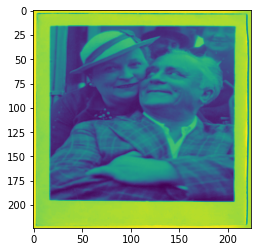

In [11]:
x, y = train_ds[25]
plt.imshow(x.numpy()[0])
print(y)
print(x.shape)

# --------------------------------------------------------------------------------------------------------------------------------------------

### Create a model
First we define a custom convolutional neural network (CNN) architecture.

In [12]:
class OurNet(nn.Module):
    def __init__(self, n_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(256, 512, 3)
        self.pool6 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 768)
        self.fc3 = nn.Linear(768, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.pool6(F.relu(self.conv6(x)))
        #print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def count_parameters(model):
  return sum([t.view(-1).size(0) for t in model.parameters()])

print(f"OurNet size={count_parameters(OurNet())}")

OurNet size=2895778


Definition of the optimiser and the loss function

In [13]:
model = OurNet(n_channels=3)

lr = 1e-3 # 1e-3 is a default lr value for Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

lossfn = nn.CrossEntropyLoss()


### Define the train function

The train_epoch function trains a machine learning model for one complete pass over the dataset, updating the model's weights based on prediction errors and returning the training accuracy, predictions, targets, and losses.

In [14]:
def train_epoch(dl, model, optimiser, lossfn, device=device, epochnum=-1):
    model = model.to(device) # redundant
    model.train(True) # make it train mode
    predictions, targets, losses = [], [], []
    
    for input_batch, target_batch in tqdm(dl):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        optimiser.zero_grad() # reset gradient accumulation
        output_batch = model(input_batch)
        _, batch_prediction = output_batch.detach().max(dim=1)
        loss = lossfn(output_batch,target_batch)
        loss.backward()# minize
        optimiser.step() # apply gradients on the weight
        _, batch_prediction = output_batch.detach().max(dim=1)
        losses.append(loss.detach())
        predictions.append(batch_prediction)
        targets.append(target_batch.detach())
    predictions, targets = [torch.cat(t, dim=0).cpu().numpy() for t in (predictions, targets)]
    acc = (predictions==targets).mean()
    return acc, predictions, targets, losses 



### Define the evaluation function

The eval_epoch function evaluates a model's performance on a given dataset without modifying the model, returning the model's accuracy, predictions, targets, and confidence scores.

In [15]:
def eval_epoch(dl, model, device=device):
    model = model.to(device) # redundant
    model.train(False) # no train mode
    predictions, targets = [], []
    with torch.no_grad():
        for input_batch, target_batch in tqdm(dl):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            output_batch = model(input_batch)
            confidence, batch_prediction = output_batch.max(dim=1)
            predictions.append(batch_prediction)
            targets.append(target_batch)

    predictions, targets = [torch.cat(t, dim=0).cpu().numpy() for t in (predictions, targets)]
    acc = (predictions==targets).mean()
    # anguelos: better avoid printing inside a function returning accuracy
    return acc, predictions, targets, confidence

### Train the model

Optimizing and evaluating the model over the number of epochs.

In [16]:
for epoch in range(3):
    tr_acc, tr_predictions, tr_targets, tr_losses = train_epoch(train_dl, model, optimizer, lossfn, device=device)
    val_acc, val_predictions, val_targets, val_confidences = eval_epoch(test_dl, model, device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [17]:
accuracy, all_predictions, all_gt, confidences = eval_epoch(test_dl, model, device=device)
print(accuracy)

  0%|          | 0/15 [00:00<?, ?it/s]

0.8454746136865342
